In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# -------------------------------
# 1) REPRODUCIBILITY & DATA LOAD
# -------------------------------
# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# -------------------------
# 2) WINDOWING THE SEQUENCES
# -------------------------
window_width = 30  # Adjust as you like

X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    # Target is the Price column only (index 0)
    y.append(data_scaled[i, 0])  
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# -------------------------
# 3) TRAIN / TEST SPLIT by Date
# -------------------------
train_mask = dates < pd.to_datetime('2024-09-01')
test_mask  = dates >= pd.to_datetime('2024-09-01')

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test   = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
test_dates  = dates[test_mask]

# -------------------------
# 4) PREPARE TENSORS / LOADERS
# -------------------------
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float().unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------------------------------------------
# 5) DEFINE MODEL(S), EARLY STOPPING, ETC.
# ---------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            # Single output for Price
            self.fc = nn.Linear(128, 1)
        
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Each Conv1d layer reduces sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2*(3 - 1)  # two Conv1d layers
            self.fc = nn.Linear(128 * conv_output_length, 1)
        
        else:
            raise ValueError("Invalid model_type: choose 'LSTM', 'GRU', 'RNN', 'CNN'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            # x shape: (batch_size, seq_len, channels)
            # For Conv1d, we want (batch_size, channels, seq_len)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # final time-step
            out = self.fc(out)
        return out

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# For reversing only the Price dimension
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# --------------------------------------------------
# 6) TRAINING FUNCTION
# --------------------------------------------------
def train_and_evaluate(model_name):
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 100
    best_train_loss = float('inf')
    
    train_losses_per_epoch = []
    
    best_model_path = f'best_model_{model_name}.pt'
    
    # If a saved model exists, load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    # -------------------------------
    # Training loop
    # -------------------------------
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch+1}")
            break
        
        # Save best model
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        
        if (epoch+1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    
    # Generate training predictions (inverse scaled)
    model.eval()
    y_train_pred_list = []
    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        with torch.no_grad():
            preds = model(X_batch)
        y_train_pred_list.append(preds.cpu().numpy())
    y_train_pred = np.concatenate(y_train_pred_list)
    y_train_pred_inv = inverse_transform(y_train_pred)

    results = {
        'model_name': model_name,
        'test_dates': test_dates,
        'train_dates': train_dates,
        'y_train_pred_inv': y_train_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
    }

    return results

# --------------------------
# 7) RUN TRAINING FOR MODELS
# --------------------------
model_names = ['LSTM', 'GRU', 'RNN', 'CNN']
all_results = {}

for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual training & test target values
y_train_inv = inverse_transform(y_train_tensor.numpy())
y_test_inv  = inverse_transform(y_test_tensor.numpy())

# For plotting
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
}

# ------------------------------------------
# 8) QUICK PLOT OF TRAIN PREDICTIONS
# ------------------------------------------
plt.figure(figsize=(14, 7))

# Actual Price (entire dataset)
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

for model_name, results in all_results.items():
    plt.plot(
        results['train_dates'],
        results['y_train_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Train Prediction'
    )

plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')
plt.title('Model Predictions on Gold Price (Train Period)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 9) PURELY MODEL-BASED FORECAST
# -------------------------------
#
# We'll demonstrate with one model, say "LSTM".
# If you want to do the same for other model types, 
# simply repeat with your chosen best model's checkpoint.
# 
# We do iterative day-by-day predictions from 
# 2024-09-01 to 2025-01-31, never peeking at actual future.

chosen_model_name = 'LSTM'  # pick which model you want to use
model_for_forecast = BaseModel(model_type=chosen_model_name).to(device)
model_for_forecast.load_state_dict(torch.load(f'best_model_{chosen_model_name}.pt', map_location=device))
model_for_forecast.eval()

test_start_date = pd.to_datetime('2024-09-01')
test_end_date   = pd.to_datetime('2025-01-31')

# Find index in df for test_start_date
# If your dataset doesn't match exactly, you might need a more flexible approach
start_idx = df.index[df['Date'] == test_start_date]
if len(start_idx) == 0:
    raise ValueError("Could not find exact 2024-09-01 in df['Date']. Please adjust your logic accordingly.")
start_idx = start_idx[0]

# We'll keep a copy of the scaled data so we can overwrite future rows with predictions
data_scaled_copy = np.copy(data_scaled)

# We will need the last `window_width` days before test_start_date as initial window
# That means we start from `start_idx - window_width`
forecast_predictions = []  # to store predictions in original scale
forecast_dates       = []  # store the corresponding dates

# We'll iterate day by day from `start_idx` up to the end of your desired test date
current_idx = start_idx
while True:
    current_date = df.loc[current_idx, 'Date']
    if current_date > test_end_date:
        break
    
    # Build the input window from current_idx - window_width to current_idx-1
    window_start = current_idx - window_width
    window_end   = current_idx  # not inclusive
    if window_start < 0:
        raise ValueError("Not enough history to create the initial window. Increase your dataset or reduce window_width.")
    
    X_input = data_scaled_copy[window_start:window_end]  # shape (window_width, 4)
    X_input = np.expand_dims(X_input, axis=0)           # shape (1, window_width, 4)
    X_input_tensor = torch.from_numpy(X_input).float().to(device)

    with torch.no_grad():
        pred_scaled = model_for_forecast(X_input_tensor).cpu().numpy().flatten()[0]  # single Price scalar

    #-----------------------------------------------
    # If you truly had a multi-output model, you'd get
    # e.g. `pred_scaled = model_for_forecast(X_input_tensor).cpu().numpy().flatten()`
    # which is shape (4,).
    #-----------------------------------------------

    # For demonstration, replicate the single predicted Price 
    # across [Price, Open, High, Low]
    predicted_row_scaled = np.array([pred_scaled]*4)

    # Overwrite the row in data_scaled_copy at `current_idx` 
    # so future days see the predicted data, not the actual.
    data_scaled_copy[current_idx] = predicted_row_scaled

    # Convert back to original scale for reporting
    # (We'll just inverse_transform the single row)
    row_2d = predicted_row_scaled.reshape(1, -1)  # shape(1,4)
    row_inv = scaler.inverse_transform(row_2d)    # shape(1,4)

    # Save forecast
    forecast_predictions.append(row_inv.flatten())
    forecast_dates.append(current_date)

    current_idx += 1  # move to the next day

forecast_predictions = np.array(forecast_predictions)  # shape(N, 4)
forecast_dates       = np.array(forecast_dates)

# Just for clarity:
# forecast_predictions[:,0] is the predicted Price
# forecast_predictions[:,1] is the predicted Open
# ... etc. (They are the same in this naive approach.)

# -----------------------------------------------
# 10) PLOT THE PURE FORECAST (NO CHEATING)
# -----------------------------------------------
plt.figure(figsize=(14, 7))

# Plot all historical actual data
plt.plot(df['Date'], df['Price'], label='Actual Price', color='black')

# Plot our forecasted Price in the test range
plt.plot(forecast_dates, forecast_predictions[:,0], label='Pure Model Forecast (Price)', color='red')

plt.axvspan(test_start_date, test_end_date, color='yellow', alpha=0.1, label='Test Forecast Window')
plt.title('Purely Model-Based Iterative Forecast (No Cheating)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Forecasting complete. `forecast_predictions` holds the 4 columns of predicted values for each day.")



Training and forecasting with model: LSTM
[LSTM] Epoch 1/100, Training Loss: 0.011139
[LSTM] Epoch 100/100, Training Loss: 0.000421

Training and forecasting with model: GRU
[GRU] Epoch 1/100, Training Loss: 0.007026


/tmp/ipykernel_1261691/4122310137.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[GRU] Epoch 100/100, Training Loss: 0.000387

Training and forecasting with model: RNN
[RNN] Epoch 1/100, Training Loss: 0.018933


/tmp/ipykernel_1261691/4122310137.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[RNN] Epoch 100/100, Training Loss: 0.000481

Training and forecasting with model: CNN
[CNN] Epoch 1/100, Training Loss: 0.003995


/tmp/ipykernel_1261691/4122310137.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


[CNN] Epoch 100/100, Training Loss: 0.000983


/tmp/ipykernel_1261691/4122310137.py:212: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_location=device))


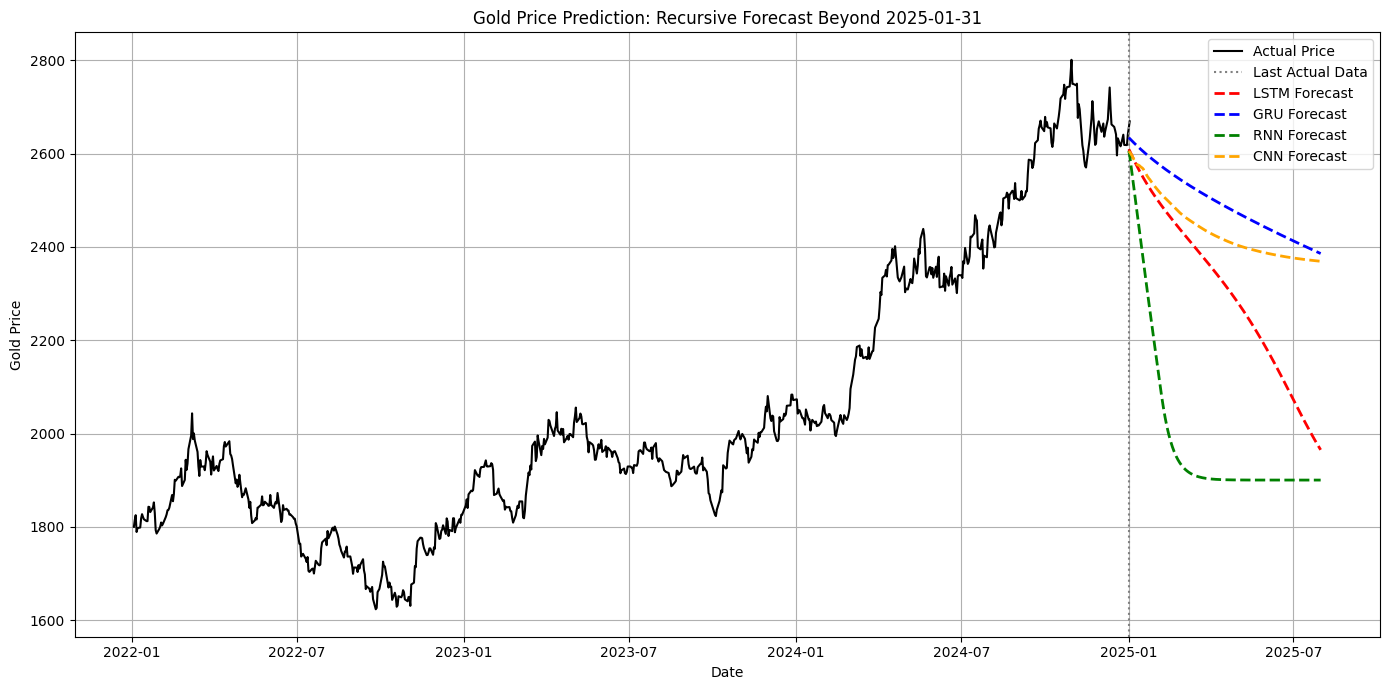

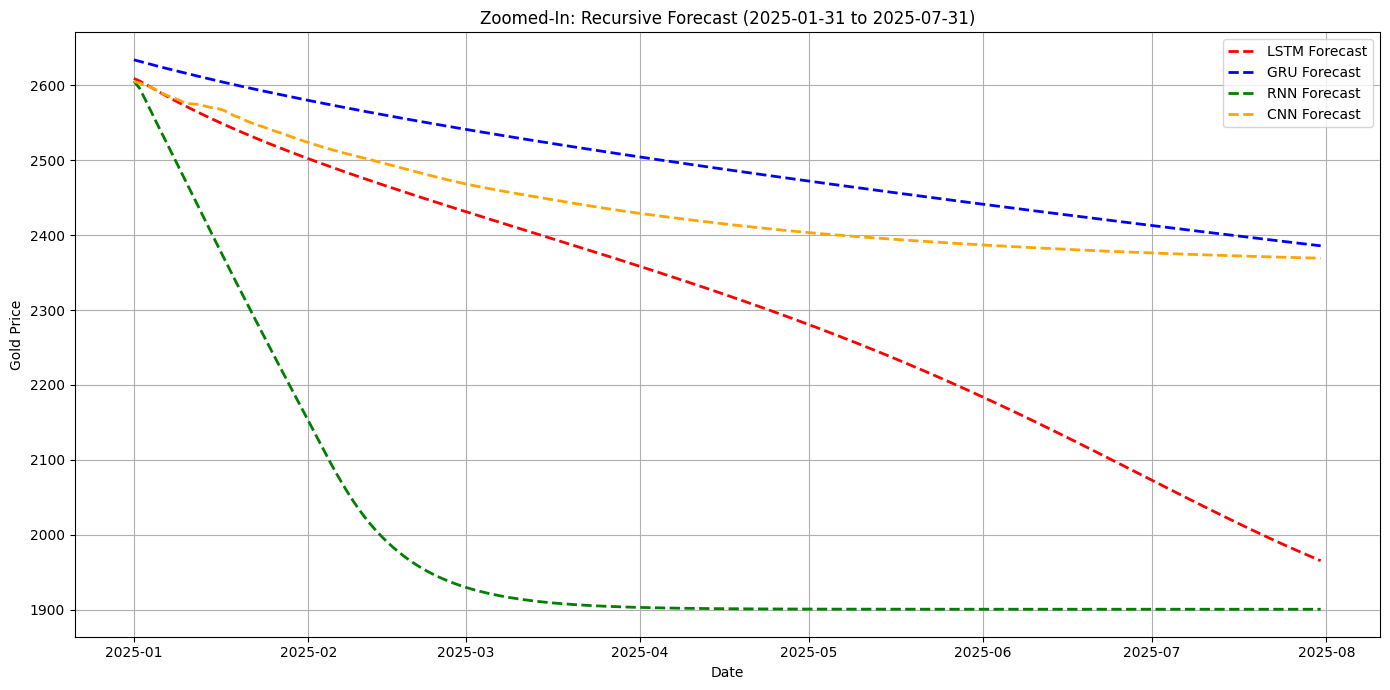

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # For activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

### 1. DATA LOADING, CLEANING, AND PREPARATION ###
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform numeric columns
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Scale all four features using MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width (number of past days used for prediction)
window_width = 30

# Prepare sequences:
# For each sample, take the previous window_width days as input,
# and the entire 4-dimensional vector of the following day as the target.
X, y, all_dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])   # shape: (window_width, 4)
    y.append(data_scaled[i])                      # target: 4-dimensional vector
    all_dates.append(df['Date'].iloc[i])
X = np.array(X)  # (num_samples, window_width, 4)
y = np.array(y)  # (num_samples, 4)
all_dates = np.array(all_dates)

# For training, use all available data (i.e. up to 2025-01-31)
train_mask = all_dates <= pd.to_datetime('2025-01-01')
X_train, y_train = X[train_mask], y[train_mask]
train_dates = all_dates[train_mask]

# Convert training data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

# Create TensorDataset and DataLoader for training
batch_size = 32  # adjust as needed
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # sequential order

### 2. MODEL DEFINITION ###
# The BaseModel is modified so that its final fully connected layer outputs 4 values.
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        input_size = len(features)  # 4 features
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)  # output 4 values
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=input_size,
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, input_size)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_output_length = window_width - 2 * (3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, input_size)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=input_size,
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, input_size)
        else:
            raise ValueError("Invalid model_type. Choose from 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")
    def forward(self, x):
        if self.model_type == 'CNN':
            # Reshape input: (batch, window_width, 4) -> (batch, 4, window_width)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # take the last time step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]  # last time step output
            out = self.fc(out)
        return out  # shape: (batch, 4)

### 3. EARLY STOPPING CLASS ###
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

### 4. TRAINING FUNCTION ###
def train_and_evaluate(model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BaseModel(model_type=model_name).to(device)
    
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 100
    best_train_loss = float('inf')
    
    # Use a new checkpoint filename to avoid loading incompatible weights.
    best_model_path = f'best_model_{model_name}_4d.pt'
    
    # Load existing model if available
    if os.path.exists(best_model_path):
        model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        scheduler.step(avg_train_loss)
        early_stopping(avg_train_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch+1}")
            break
        if avg_train_loss < best_train_loss:
            best_train_loss = avg_train_loss
            torch.save(model.state_dict(), best_model_path)
        if (epoch+1) % 100 == 0 or epoch == 0:
            print(f'[{model_name}] Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}')
    
    # Load the best model
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    return model

### 5. RECURSIVE FORECASTING FUNCTION ###
def recursive_forecast(model, initial_window, forecast_horizon, device):
    """
    Recursively predict the next 'forecast_horizon' days.
    
    Parameters:
        model: trained model.
        initial_window: torch.Tensor of shape (window_width, 4) representing the last known window.
        forecast_horizon: number of days to forecast.
        device: torch device.
        
    Returns:
        predictions: NumPy array of shape (forecast_horizon, 4) containing the forecasted values.
    """
    model.eval()
    preds = []
    current_window = initial_window.clone().to(device)
    for _ in range(forecast_horizon):
        input_tensor = current_window.unsqueeze(0)
        with torch.no_grad():
            pred = model(input_tensor)
        pred = pred.squeeze(0)
        preds.append(pred.cpu().numpy())
        # Form next window: drop first row and append new prediction row.
        current_window = torch.cat((current_window[1:], pred.unsqueeze(0)), dim=0)
    return np.array(preds)

### 6. TRAIN AND FORECAST WITH MULTIPLE MODELS ###
model_names = ['LSTM', 'GRU', 'RNN', 'CNN']  # You can add 'EnhancedLSTM' if desired.
all_forecasts = {}  # dictionary to store forecasted prices (first column) for each model

# Define a manual forecast period beyond the CSV data.
# Although the CSV stops at 2025-01-31, we want forecasts from 2025-01-31 to 2025-07-31.
forecast_start = pd.to_datetime('2025-01-01')
forecast_end = pd.to_datetime('2025-07-31')
forecast_dates = pd.date_range(start=forecast_start, end=forecast_end, freq='D')
forecast_horizon = len(forecast_dates)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# (Optional: define colors for plotting)
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple'
}

for model_name in model_names:
    print(f"\nTraining and forecasting with model: {model_name}")
    model = train_and_evaluate(model_name)
    # Use the last training window from the training set as the seed.
    initial_window = X_train_tensor[-1]
    test_preds_scaled = recursive_forecast(model, initial_window, forecast_horizon, device)
    # Inverse transform the predictions to the original scale.
    test_preds_inv = scaler.inverse_transform(test_preds_scaled)
    predicted_prices = test_preds_inv[:, 0]  # take the predicted 'Price' (first column)
    all_forecasts[model_name] = predicted_prices

### 7. PLOTTING RESULTS ###
plt.figure(figsize=(14, 7))
# Plot actual prices (inverse transformed) for all dates in the CSV.
all_prices_inv = scaler.inverse_transform(data_scaled)[:, 0]
plt.plot(df['Date'], all_prices_inv, color='black', label='Actual Price')
# Mark the last available actual data date.
plt.axvline(pd.to_datetime('2025-01-01'), color='gray', linestyle=':', label='Last Actual Data')
# Plot forecasts from each model over the forecast period.
for model_name in model_names:
    plt.plot(forecast_dates, all_forecasts[model_name],
             color=model_colors[model_name], linestyle='--', linewidth=2,
             label=f'{model_name} Forecast')
plt.title('Gold Price Prediction: Recursive Forecast Beyond 2025-01-31')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in Plot for the forecast period.
plt.figure(figsize=(14, 7))
for model_name in model_names:
    plt.plot(forecast_dates, all_forecasts[model_name],
             color=model_colors[model_name], linestyle='--', linewidth=2,
             label=f'{model_name} Forecast')
plt.title('Zoomed-In: Recursive Forecast (2025-01-31 to 2025-07-31)')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Training LSTM model...
[LSTM] Epoch 100/800, Training Loss: 0.002620, Validation Loss: 0.001868
Early stopping triggered
[LSTM] Early stopping at epoch 152
[LSTM] Test Loss: 0.012379
[LSTM] Test MAPE: 31.42%
[LSTM] Test Accuracy: 68.58%

Training GRU model...
[GRU] Epoch 100/800, Training Loss: 0.001531, Validation Loss: 0.001138
[GRU] Epoch 200/800, Training Loss: 0.001220, Validation Loss: 0.000896
[GRU] Epoch 300/800, Training Loss: 0.001218, Validation Loss: 0.000947
[GRU] Epoch 400/800, Training Loss: 0.001083, Validation Loss: 0.000822
[GRU] Epoch 500/800, Training Loss: 0.001055, Validation Loss: 0.000868
Early stopping triggered
[GRU] Early stopping at epoch 511
[GRU] Test Loss: 0.001139
[GRU] Test MAPE: 10.10%
[GRU] Test Accuracy: 89.90%

Training RNN model...
[RNN] Epoch 100/800, Training Loss: 0.001482, Validation Loss: 0.001616
Early stopping triggered
[RNN] Early stopping at epoch 152
[RNN] Test Loss: 0.012069
[RNN] Test MAPE: 30.42%
[RNN] Test Accuracy: 69.58%

Training 

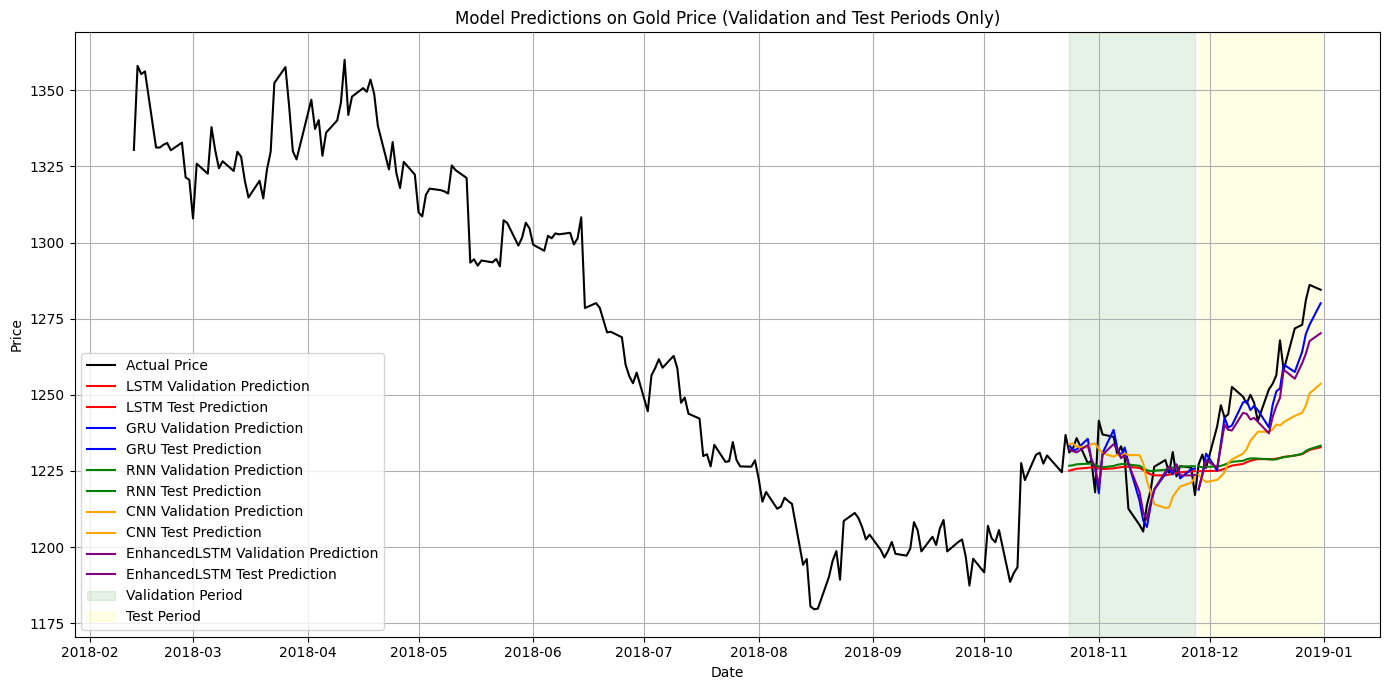

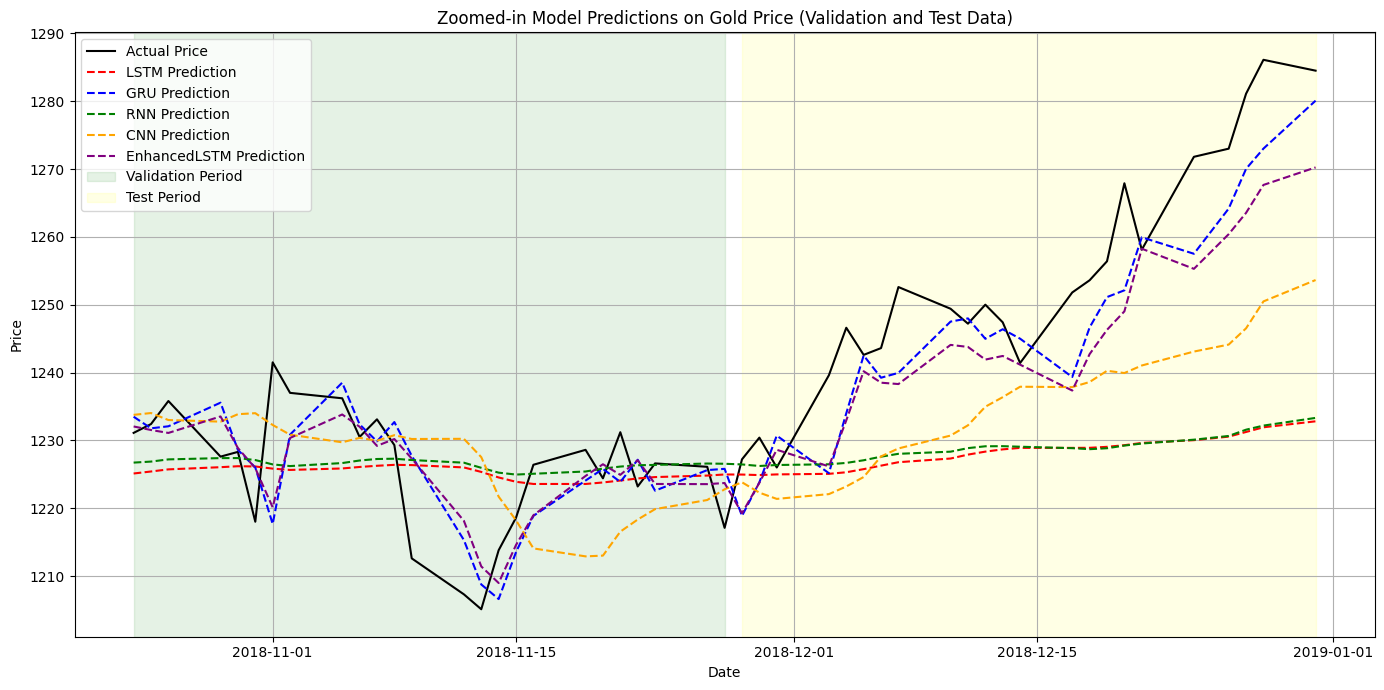

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # Ensure F is imported for activation functions
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
import matplotlib.dates as mdates

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Load and prepare data
df = pd.read_csv('Gold Price_Year 2018.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Transform columns to numerical format
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Check for duplicates and nulls
assert df.duplicated().sum() == 0, "Duplicate rows found!"
assert df.isnull().sum().sum() == 0, "Missing values found!"

# Features to include
features = ['Price', 'Open', 'High', 'Low']
data = df[features].values

# Data scaling (scale each feature individually)
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Window width
window_width = 30  # Adjusted window width for experimentation

# Prepare sequences and corresponding dates
X, y, dates = [], [], []
for i in range(window_width, len(data_scaled)):
    X.append(data_scaled[i - window_width:i])
    y.append(data_scaled[i, 0])  # Assuming 'Price' is the target
    dates.append(df['Date'].iloc[i])

X = np.array(X)
y = np.array(y)
dates = np.array(dates)

# Ensure that dates and y have the same length
assert len(dates) == len(y), "Mismatch between dates and y lengths"

# Split the data into training, validation, and test sets based on dates
train_mask = dates < pd.to_datetime('2018-10-24')
val_mask = (dates >= pd.to_datetime('2018-10-24')) & (dates < pd.to_datetime('2018-11-28'))
test_mask = dates >= pd.to_datetime('2018-11-28')

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

train_dates = dates[train_mask]
val_dates = dates[val_mask]
test_dates = dates[test_mask]

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().unsqueeze(1)
X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).float().unsqueeze(1)
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float().unsqueeze(1)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # Adjusted batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # Set shuffle=False for sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### All the above are the data cleaning and preparation steps ### 


# Define the models
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=len(features),
                hidden_size=128,
                num_layers=2,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1,
            )
            self.fc = nn.Linear(128, 1)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=len(features), out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Calculate the output size after Conv1d layers
            # Each Conv1d layer reduces the sequence length by (kernel_size - 1)
            conv_output_length = window_width - 2 * (3 - 1)  # Two Conv1d layers with kernel_size=3
            self.fc = nn.Linear(128 * conv_output_length, 1)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=len(features),
                hidden_size=128,
                num_layers=3,
                batch_first=True,
                dropout=0.2,
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(128)
            self.fc = nn.Linear(128, 1)
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # Reshape for Conv1d: (batch_size, channels, seq_length)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
            
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# Define the inverse_transform function globally
def inverse_transform(y_scaled):
    """
    Inverse transform the scaled 'Price' values back to the original scale.
    Assumes that the scaler was fit on all features.
    """
    y_scaled = np.array(y_scaled).reshape(-1, 1)
    # Create a placeholder for other features with zeros
    zeros = np.zeros((y_scaled.shape[0], len(features) - 1))
    y_combined = np.hstack((y_scaled, zeros))
    y_inv = scaler.inverse_transform(y_combined)
    return y_inv[:, 0]

# Function to train and evaluate a model
def train_and_evaluate(model_name):
    # Initialize the model
    model = BaseModel(model_type=model_name).to(device)
    
    # Define the criterion, optimizer, and scheduler
    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=150, min_delta=0)
    num_epochs = 800
    best_val_loss = float('inf')
    
    # Lists to store loss history
    train_losses_per_epoch = []
    val_losses_per_epoch = []
    
    # Path to save the best model checkpoint
    best_model_path = f'best_model_{model_name}.pt'
    
    # Check if a saved model exists and load it
    if os.path.exists(best_model_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        print(f"Loaded existing model for {model_name} from {best_model_path}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)
        train_losses_per_epoch.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_output = model(X_batch)
                val_loss = criterion(val_output, y_batch)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)
        val_losses_per_epoch.append(avg_val_loss)
        
        # Scheduler step
        scheduler.step(avg_val_loss)
        
        # Check for early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print(f"[{model_name}] Early stopping at epoch {epoch + 1}")
            break
        
        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
        
        # Print losses every 100 epochs
        if (epoch + 1) % 100 == 0:
            print(f'[{model_name}] Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_val_loss:.6f}')
    
    # Load the best model state
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    
    # Evaluate on test data
    model.eval()
    test_losses = []
    y_test_pred_list = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            test_losses.append(loss.item())
            y_test_pred_list.append(y_pred.cpu().numpy())
    avg_test_loss = np.mean(test_losses)
    print(f'[{model_name}] Test Loss: {avg_test_loss:.6f}')
    
    # Concatenate test predictions
    y_test_pred_array = np.concatenate(y_test_pred_list, axis=0)
    
    # Calculate MAPE and accuracy
    mape = mean_absolute_percentage_error(y_test_tensor.numpy(), y_test_pred_array)
    accuracy = 100 - mape * 100
    print(f'[{model_name}] Test MAPE: {mape * 100:.2f}%')
    print(f'[{model_name}] Test Accuracy: {accuracy:.2f}%')
    
    # Collect predictions over validation and test sets
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_pred_batch = model(X_batch)
            y_val_pred.append(y_pred_batch.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)
    
    y_test_pred = y_test_pred_array
    
    # Inverse scaling
    y_val_pred_inv = inverse_transform(y_val_pred)
    y_test_pred_inv = inverse_transform(y_test_pred)
    
    # Store results
    results = {
        'model_name': model_name,
        'val_dates': val_dates,
        'test_dates': test_dates,
        'y_val_pred_inv': y_val_pred_inv,
        'y_test_pred_inv': y_test_pred_inv,
        'train_losses_per_epoch': train_losses_per_epoch,
        'val_losses_per_epoch': val_losses_per_epoch,
    }
    
    return results

# List of models to train
model_names = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']

# Dictionary to store results
all_results = {}
    
# Train and evaluate each model
for model_name in model_names:
    print(f"\nTraining {model_name} model...")
    results = train_and_evaluate(model_name)
    all_results[model_name] = results

# Inverse transform the actual validation and test target values
y_val_inv = inverse_transform(y_val_tensor.numpy())
y_test_inv = inverse_transform(y_test_tensor.numpy())

# Colors for different models
model_colors = {
    'LSTM': 'red',
    'GRU': 'blue',
    'RNN': 'green',
    'CNN': 'orange',
    'EnhancedLSTM': 'purple',
}

# Plotting the full dataset with predictions over validation and test sets only
plt.figure(figsize=(14, 7))

# Actual Price
plt.plot(dates, inverse_transform(y), color='black', label='Actual Price')

# Plot predicted data for each model over validation and test datasets only
for model_name, results in all_results.items():
    # Plot validation predictions
    plt.plot(
        results['val_dates'],
        results['y_val_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Validation Prediction'
    )
    # Plot test predictions
    plt.plot(
        results['test_dates'],
        results['y_test_pred_inv'],
        color=model_colors[model_name],
        linestyle='-',
        label=f'{model_name} Test Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Model Predictions on Gold Price (Validation and Test Periods Only)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoomed-in plot for validation and test data with dashed lines for models
plt.figure(figsize=(14, 7))

# Combine validation and test dates and actual prices
zoom_dates = np.concatenate((val_dates, test_dates))
zoom_actual = np.concatenate((y_val_inv, y_test_inv))

# Plot actual prices for validation and test periods
plt.plot(
    zoom_dates,
    zoom_actual,
    color='black',
    label='Actual Price'
)

# Plot predicted data for each model during validation and test periods with dashed lines
for model_name, results in all_results.items():
    # Combine validation and test predictions
    y_pred_combined = np.concatenate((results['y_val_pred_inv'], results['y_test_pred_inv']))
    model_dates = np.concatenate((results['val_dates'], results['test_dates']))
    plt.plot(
        model_dates,
        y_pred_combined,
        color=model_colors[model_name],
        linestyle='--',  # Dashed lines
        label=f'{model_name} Prediction'
    )

# Highlight validation and test periods
plt.axvspan(val_dates.min(), val_dates.max(), color='green', alpha=0.1, label='Validation Period')
plt.axvspan(test_dates.min(), test_dates.max(), color='yellow', alpha=0.1, label='Test Period')

plt.title('Zoomed-in Model Predictions on Gold Price (Validation and Test Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

###############################################################################
# 1) LOAD AND CLEAN YOUR DATA
###############################################################################
df = pd.read_csv('Gold Futures Historical Data_3Yr.csv')  # <-- Your CSV file
df.drop(['Vol.', 'Change %'], axis=1, inplace=True, errors='ignore')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert numeric columns from strings (with commas) to float
num_cols = df.columns.drop(['Date'])
df[num_cols] = df[num_cols].replace({',': ''}, regex=True)
df[num_cols] = df[num_cols].astype('float64')

# Let’s define the features to use
features = ['Price', 'Open', 'High', 'Low']
# If your CSV has these columns named exactly that,
# otherwise adjust to match your CSV column names.

###############################################################################
# 2) SPLIT DATA INTO TRAIN AND TEST SETS BY DATE
###############################################################################
train_end_date = pd.to_datetime('2025-01-02')
test_end_date  = pd.to_datetime('2025-02-28')

train_mask = df['Date'] < train_end_date
test_mask  = (df['Date'] >= train_end_date) & (df['Date'] <= test_end_date)

# Target is 'Price' (predicting same-day or next-day, etc.)
target_col = 'Price'
y = df[target_col].values
X = df[features].values

dates = df['Date'].values  # keep for plotting

# Split
X_train = X[train_mask]
y_train = y[train_mask]
dates_train = df['Date'][train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
dates_test = df['Date'][test_mask]

###############################################################################
# 3) (OPTIONAL) CREATE WINDOWED SEQUENCES FOR LSTM/GRU/RNN/CNN
###############################################################################
def create_sequences(X_data, y_data, window_size=14):
    """
    Create a list of (sequence, target) pairs from X_data, y_data
    for RNN-based models.
    """
    Xs, ys = [], []
    for i in range(len(X_data) - window_size + 1):
        seq_x = X_data[i : (i + window_size)]
        seq_y = y_data[i + window_size - 1]  # predict the last day in the window
        Xs.append(seq_x)
        ys.append(seq_y)
    return np.array(Xs), np.array(ys)

window_size =14  # can be tuned

X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
X_test_seq,  y_test_seq  = create_sequences(X_test,  y_test,  window_size)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_seq,  dtype=torch.float32).unsqueeze(-1)

X_test_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test_seq,   dtype=torch.float32).unsqueeze(-1)

###############################################################################
# 4) DEFINE THE MODEL CLASS (BaseModel)
###############################################################################
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM', window_width=30, num_features=4):
        super(BaseModel, self).__init__()
        self.model_type = model_type
        
        hidden_size = 128
        num_layers  = 2
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(
                input_size=num_features,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=0.1
            )
            self.fc = nn.Linear(hidden_size, 1)
        
        elif model_type == 'GRU':
            self.rnn = nn.GRU(
                input_size=num_features,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                dropout=0.1
            )
            self.fc = nn.Linear(hidden_size, 1)
        
        elif model_type == 'RNN':
            self.rnn = nn.RNN(
                input_size=num_features,
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True,
                nonlinearity='relu',
                dropout=0.1
            )
            self.fc = nn.Linear(hidden_size, 1)
        
        elif model_type == 'CNN':
            # Example kernel_size=3
            self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            
            # For a window_width and 2 conv layers w/ kernel_size=3:
            conv_output_length = window_width - 2*(3 - 1)
            self.fc = nn.Linear(128 * conv_output_length, 1)
        
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(
                input_size=num_features,
                hidden_size=hidden_size,
                num_layers=3,
                batch_first=True,
                dropout=0.2
            )
            self.dropout = nn.Dropout(0.2)
            self.bn = nn.BatchNorm1d(hidden_size)
            self.fc = nn.Linear(hidden_size, 1)
        
        else:
            raise ValueError("Invalid model_type. Choose 'LSTM', 'GRU', 'RNN', 'CNN', or 'EnhancedLSTM'.")

    def forward(self, x):
        # x shape: (batch_size, seq_len, num_features)
        if self.model_type == 'CNN':
            # for CNN, reshape to (batch_size, channels, seq_len)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)           # out: (batch_size, seq_len, hidden_size)
            out = out[:, -1, :]           # last hidden state
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        
        else:
            # LSTM, GRU, RNN
            out, _ = self.rnn(x)          # out: (batch_size, seq_len, hidden_size)
            out = out[:, -1, :]           # take last time step
            out = self.fc(out)
        
        return out

###############################################################################
# 5) TRAIN EACH MODEL
###############################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Move data to device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor  = X_test_tensor.to(device)
y_test_tensor  = y_test_tensor.to(device)

model_types = ['LSTM', 'GRU', 'RNN', 'CNN', 'EnhancedLSTM']
models = {}
num_epochs = 800  # example

for mtype in model_types:
    print(f"\n=== Training {mtype} ===")
    model = BaseModel(model_type=mtype, window_width=window_size, num_features=len(features)).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        out = model(X_train_tensor)
        loss = criterion(out, y_train_tensor)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Store the trained model
    models[mtype] = model


###############################################################################
# 6) GENERATE PREDICTIONS
###############################################################################
for model in models.values():
    model.eval()

preds_train = {}
preds_test = {}

# We'll generate predictions only for the portion that has valid windows.
# That means the "dates_train" is windowed to exclude the first (window_size - 1) points,
# same for test. Let's keep track of that offset:
train_dates_for_plot = dates_train[window_size-1:] if len(dates_train) >= window_size else dates_train
test_dates_for_plot  = dates_test[window_size-1:]  if len(dates_test) >= window_size else dates_test

with torch.no_grad():
    for name, model in models.items():
        # Predictions on training set
        y_hat_train = model(X_train_tensor).squeeze().cpu().numpy()
        # Predictions on test set
        y_hat_test  = model(X_test_tensor).squeeze().cpu().numpy()
        
        preds_train[name] = y_hat_train
        preds_test[name]  = y_hat_test

###############################################################################
# 7) PLOT ACTUAL VS. PREDICTIONS
###############################################################################
plt.figure(figsize=(12, 6))

# Plot the actual training portion
plt.plot(train_dates_for_plot, y_train_seq, label='Actual Price (Train)', color='black', linewidth=2)

# If you have actual data in the test window
if len(test_dates_for_plot) == len(y_test_seq) and len(y_test_seq) > 0:
    plt.plot(test_dates_for_plot, y_test_seq, label='Actual Price (Test)', color='black', linestyle='--')

# Now plot each model's training predictions
for name, preds in preds_train.items():
    plt.plot(train_dates_for_plot, preds, label=f'{name} (Train)')

# Plot each model's test predictions
for name, preds in preds_test.items():
    plt.plot(test_dates_for_plot, preds, label=f'{name} (Test)', linestyle='--')

# Optional vertical line for train/test split
plt.axvline(x=train_end_date, color='gray', linestyle='--', label='Train/Test Split')

plt.title("Gold Price Predictions: Training and Testing Windows")
plt.xlabel("Date")
plt.ylabel("Gold Price")
plt.legend()
plt.grid(True)
plt.show()
